C:\Users\toho2\AppData\Local\Temp\ipykernel_33444\3419283129.py:99: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_complete_years_to_present)


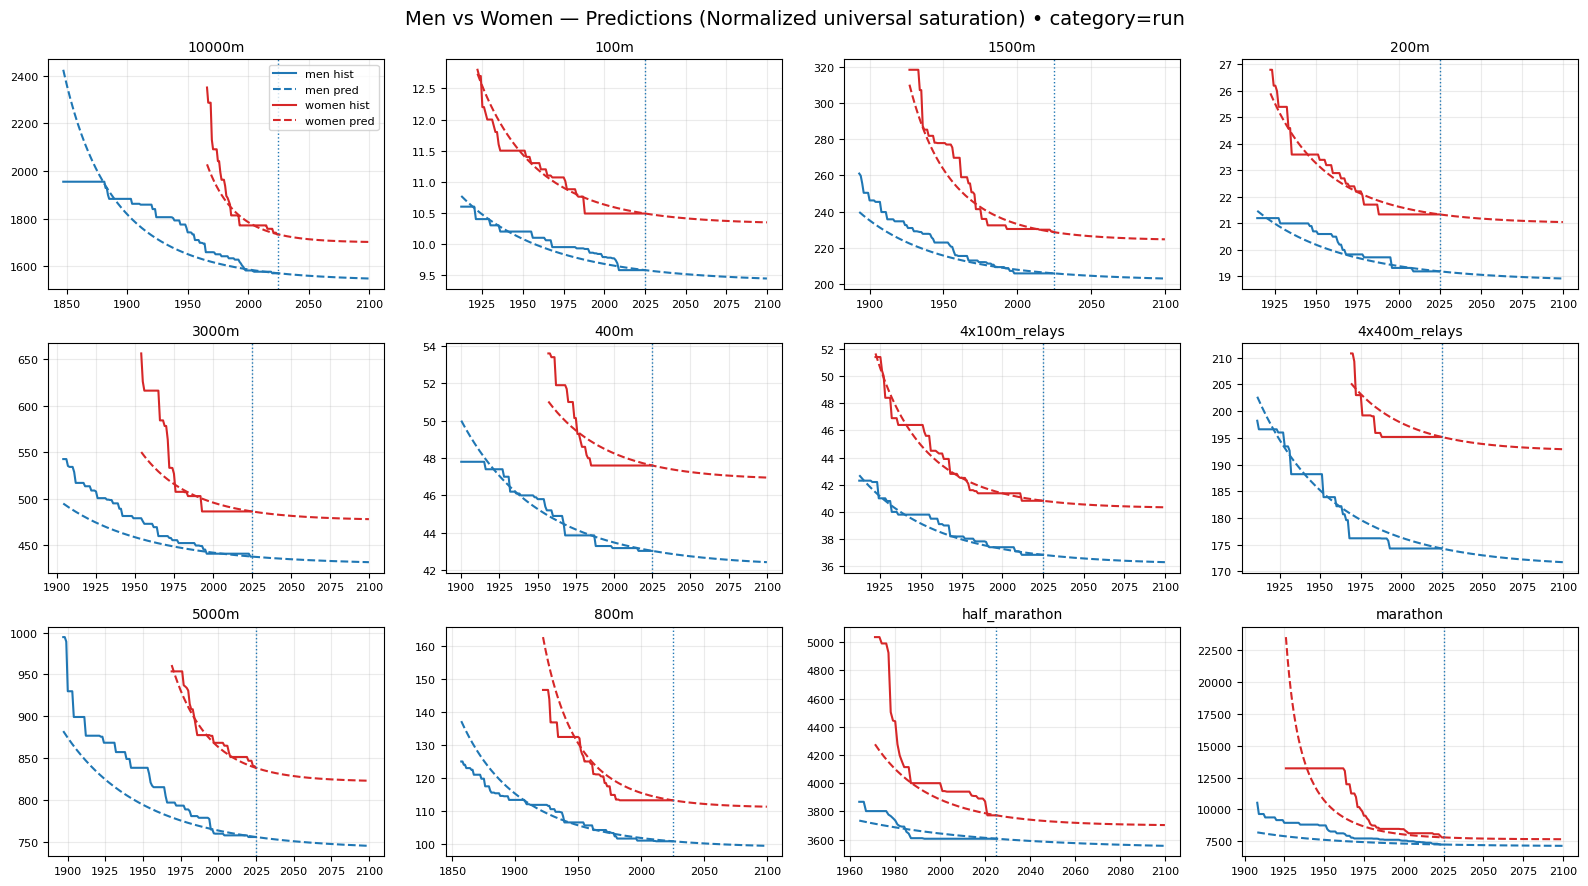

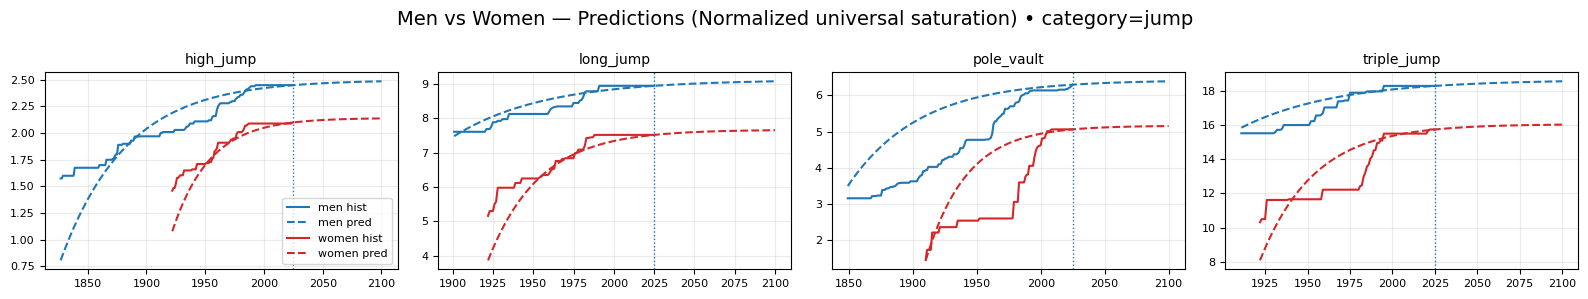

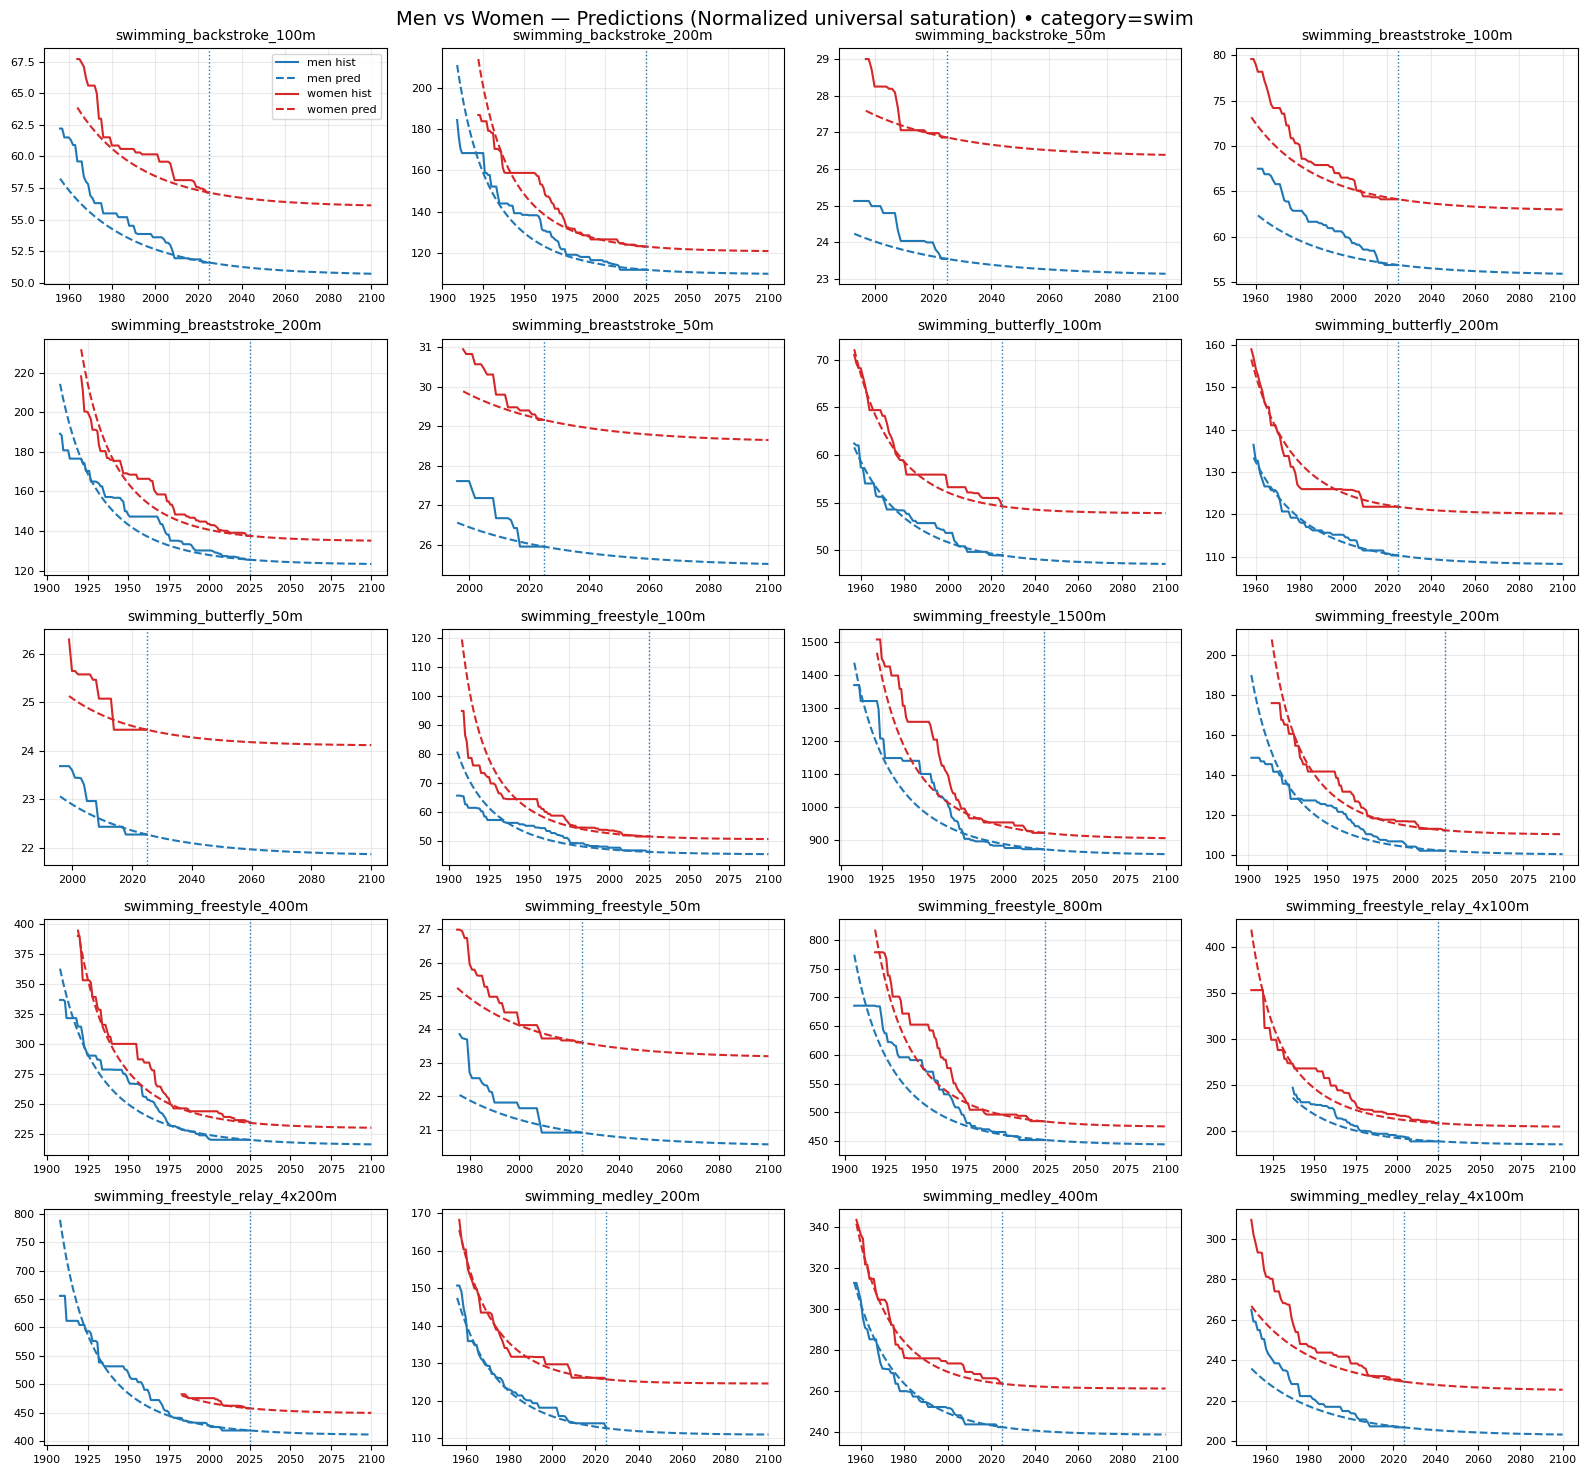

In [62]:
# ===========================================
# 0) Imports
# ===========================================
from pathlib import Path
import numpy as np
import pandas as pd

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import math

# ===========================================
# 1) Reading the file
# ===========================================
# Project root = parent directory of notebooks/
PROJECT_ROOT = Path().resolve().parent

# Data directories
DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

# Input file: cleaned all events results
input_path = DATA_PROCESSED / "all_events_results_clean.csv"

# "Present year" for your thesis context
CURRENT_YEAR = 2025
YEAR_END = 2100

df_raw = pd.read_csv(input_path, parse_dates=["date"])

# Basic schema check
required_cols = [
    "event","sex","measure","date",
    "time_seconds","mark_meters",
    "category","subcategory"
]
missing = [c for c in required_cols if c not in df_raw.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# ===========================================
# 2) Necessary changes / preparation
#    - build annual best-so-far per (event, sex)
#    - extend flat to CURRENT_YEAR
#    - create unified performance where higher=better
# ===========================================
df = df_raw.copy()
df["year"] = df["date"].dt.year

# Keep rows with valid numeric measurement
time_mask = (df["measure"] == "time") & df["time_seconds"].notna()
mark_mask = (df["measure"] == "mark") & df["mark_meters"].notna()
df = df[time_mask | mark_mask].copy()

# Unify performance: higher is better
# time -> performance = 1 / seconds
# mark -> performance = meters
df["performance"] = np.where(
    df["measure"] == "time",
    1.0 / df["time_seconds"].astype(float),
    df["mark_meters"].astype(float)
)

# Annual best performance per (event, sex, year)
annual_best = (
    df.groupby(["event","sex","measure","year"], as_index=False)
      .agg(
          performance=("performance","max"),
          category=("category","first"),
          subcategory=("subcategory","first"),
      )
    .sort_values(["event","sex","year"])
)

# Best-so-far record curve (monotonic non-decreasing in performance)
annual_best["perf_best_so_far"] = (
    annual_best.groupby(["event","sex"])["performance"].cummax()
)

# Extend each (event, sex) to a complete year grid up to CURRENT_YEAR
def _complete_years_to_present(g: pd.DataFrame) -> pd.DataFrame:
    min_y = int(g["year"].min())
    max_y = max(int(g["year"].max()), CURRENT_YEAR)
    years = pd.Index(range(min_y, max_y + 1), name="year")

    g2 = g.set_index("year").reindex(years).reset_index()

    # Fill identifiers/constants
    for col in ["event","sex","measure","category","subcategory"]:
        g2[col] = g[col].iloc[0]

    # Carry forward record
    g2["perf_best_so_far"] = g2["perf_best_so_far"].ffill().bfill()

    return g2

record_curve = (
    annual_best.groupby(["event","sex"], group_keys=False)
              .apply(_complete_years_to_present)
              .reset_index(drop=True)
)

# Keep a clean metadata table (constant per event/sex)
event_meta = (
    record_curve.groupby(["event","sex"], as_index=False)
               .agg(
                   measure=("measure","first"),
                   category=("category","first"),
                   subcategory=("subcategory","first")
               )
)

# Optional: drop very short series
min_points = 10
counts = record_curve.groupby(["event","sex"]).size().reset_index(name="n")
valid_pairs = counts[counts["n"] >= min_points][["event","sex"]]
record_curve = record_curve.merge(valid_pairs, on=["event","sex"], how="inner")

# ===========================================
# 3) Near-ceiling normalized universal saturation model
#    (pooled within category/subcategory/sex)
# ===========================================
rc = record_curve.copy()
rc["t_to_present"] = (CURRENT_YEAR - rc["year"]).astype(int)

# Current (2025) best per event/sex
perf_current = (
    rc[rc["year"] == CURRENT_YEAR]
    .groupby(["event", "sex"], as_index=False)
    .agg(perf_current=("perf_best_so_far", "max"))
)
rc = rc.merge(perf_current, on=["event", "sex"], how="left")

if rc["perf_current"].isna().any():
    missing_pairs = rc.loc[rc["perf_current"].isna(), ["event","sex"]].drop_duplicates()
    raise ValueError(f"Missing perf_current for some pairs:\n{missing_pairs}")

# Normalized performance ratio (<=1 in the past, =1 at 2025)
rc["p_norm"] = rc["perf_best_so_far"] / rc["perf_current"]
rc = rc[rc["p_norm"].between(0.05, 1.05)].copy()  # sanity filter

# Model: p_norm(t) = 1 + rho - rho*exp(beta*t_to_present)
def pnorm_model(t, rho, beta):
    return 1.0 + rho - rho * np.exp(beta * t)

fits = {}

# Choose reasonable headroom bounds (adjust if you want)
# rho = 0.002 means +0.2% performance max (time improves ~0.2%)
RHO_MAX = 0.02   # +2% performance max
BETA_MAX = 0.05  # keep curve gentle; prevents crazy exponentials

for (cat, subcat, sex), g in rc.groupby(["category", "subcategory", "sex"]):
    x = g["t_to_present"].to_numpy(float)
    y = g["p_norm"].to_numpy(float)

    if len(g) < 80:
        continue

    # Start near tiny headroom
    p0 = [0.005, 0.01]  # rho=0.5%, beta small

    try:
        popt, _ = curve_fit(
            pnorm_model,
            x, y,
            p0=p0,
            bounds=([0.0, 0.0], [RHO_MAX, BETA_MAX]),
            maxfev=200_000
        )
        fits[(cat, subcat, sex)] = popt
    except Exception:
        continue

def predict_event_sex(g: pd.DataFrame, rho: float, beta: float, year_end: int = YEAR_END) -> pd.DataFrame:
    event = g["event"].iloc[0]
    sex = g["sex"].iloc[0]
    measure = g["measure"].iloc[0]
    category = g["category"].iloc[0]
    subcategory = g["subcategory"].iloc[0]
    perf_curr = float(g["perf_current"].iloc[0])

    years = np.arange(int(g["year"].min()), year_end + 1)
    t = (CURRENT_YEAR - years).astype(float)  # can be negative in future

    p_pred = pnorm_model(t, rho, beta)

    # Safety: keep within plausible range
    p_pred = np.clip(p_pred, 0.2, 1.0 + rho)

    perf_pred = p_pred * perf_curr

    out = pd.DataFrame({
        "event": event,
        "sex": sex,
        "measure": measure,
        "category": category,
        "subcategory": subcategory,
        "year": years,
        "perf_pred": perf_pred,
        "p_pred": p_pred,
        "rho": rho,
        "beta": beta,
        "model": "normalized_near_ceiling"
    })

    # Convert to native units for plotting
    if measure == "time":
        out["y_pred"] = 1.0 / out["perf_pred"]
    else:
        out["y_pred"] = out["perf_pred"]

    return out

preds_list = []
for (event, sex), g in rc.groupby(["event", "sex"]):
    key = (g["category"].iloc[0], g["subcategory"].iloc[0], sex)
    if key not in fits:
        continue
    rho, beta = fits[key]
    preds_list.append(predict_event_sex(g, rho, beta))

preds = pd.concat(preds_list, ignore_index=True)

# ===========================================
# 4) Build plot_df robustly (metadata not by year!)
# ===========================================
hist = record_curve[["event","sex","year","perf_best_so_far"]].copy()

plot_df = preds.merge(hist, on=["event","sex","year"], how="left")

plot_df["y_hist"] = np.where(
    plot_df["measure"] == "time",
    1.0 / plot_df["perf_best_so_far"],
    plot_df["perf_best_so_far"]
)

plot_df.to_csv(PROJECT_ROOT / "data" / "predictions" / "predictions_normalized_near_ceiling.csv", index=False)


# ===========================================
# 4) Plot grid: each subplot = one event
#    with men + women together
# ===========================================

def plot_grid_men_women(
    plot_df: pd.DataFrame,
    category: str | None = None,
    subcategory: str | None = None,
    year_split: int = CURRENT_YEAR,
    max_events: int = 24,
    ncols: int = 4,
    invert_time_axis: bool = True,
):
    d = plot_df.copy()
    if category is not None:
        d = d[d["category"] == category]
    if subcategory is not None:
        d = d[d["subcategory"] == subcategory]

    events = sorted(d["event"].unique())
    if not events:
        print("No events to plot for the selected filters.")
        return

    events = events[:max_events]
    n = len(events)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(4*ncols, 3*nrows),
        squeeze=False
    )
    axes = axes.flatten()

    for i, event in enumerate(events):
        ax = axes[i]
        g = d[d["event"] == event].sort_values("year")
        if g.empty:
            ax.axis("off")
            continue

        measure = g["measure"].iloc[0]

        for sex, color in [("men", "tab:blue"), ("women", "tab:red")]:
            gs = g[g["sex"] == sex].sort_values("year")
            if gs.empty:
                continue

            # Historical (solid)
            gh = gs[gs["y_hist"].notna()]
            if not gh.empty:
                ax.plot(gh["year"], gh["y_hist"], color=color, linewidth=1.5, label=f"{sex} hist")

            # Prediction (dashed)
            ax.plot(gs["year"], gs["y_pred"], color=color, linestyle="--", linewidth=1.5, label=f"{sex} pred")

        ax.axvline(year_split, linestyle=":", linewidth=1)
        ax.set_title(event, fontsize=10)
        ax.grid(True, alpha=0.25)
        ax.tick_params(labelsize=8)

        if measure == "time" and invert_time_axis:
            ax.invert_yaxis()

        # Reduce legend clutter: show only in first subplot
        if i == 0:
            ax.legend(fontsize=8)
        else:
            ax.legend().remove()

    # Turn off extra axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    title = "Men vs Women — Predictions (Normalized universal saturation)"
    if category:
        title += f" • category={category}"
    if subcategory:
        title += f" • subcategory={subcategory}"

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Example usage:
#  - All running events (first 24)
plot_grid_men_women(plot_df, category="run", max_events=50, invert_time_axis=False)

#  - Sprint only (first 24)
# plot_grid_men_women(plot_df, category="run", subcategory="sprint", max_events=24)

#  - Jumps
plot_grid_men_women(plot_df, category="jump", max_events=50, invert_time_axis=False)

#  - Swim: freestyle
plot_grid_men_women(plot_df, category="swim", max_events=50, invert_time_axis=False)


In [60]:
plot_df

,event,sex,measure,category,subcategory,year,perf_pred,p_pred,rho,beta,model,y_pred,perf_best_so_far,y_hist
0,10000m,men,time,run,long,1847,0.000412,0.647967,0.02,0.016423,normalized_near_ceiling,2424.506186,0.000512,1955.0
1,10000m,men,time,run,long,1848,0.000416,0.654027,0.02,0.016423,normalized_near_ceiling,2402.041836,0.000512,1955.0
2,10000m,men,time,run,long,1849,0.000420,0.659988,0.02,0.016423,normalized_near_ceiling,2380.345903,0.000512,1955.0
3,10000m,men,time,run,long,1850,0.000424,0.665852,0.02,0.016423,normalized_near_ceiling,2359.382403,0.000512,1955.0
4,10000m,men,time,run,long,1851,0.000428,0.671621,0.02,0.016423,normalized_near_ceiling,2339.117550,0.000512,1955.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12111,triple_jump,women,mark,jump,jump,2096,16.016078,1.017540,0.02,0.029515,normalized_near_ceiling,16.016078,NaN,NaN
12112,triple_jump,women,mark,jump,jump,2097,16.017204,1.017611,0.02,0.029515,normalized_near_ceiling,16.017204,NaN,NaN
12113,triple_jump,women,mark,jump,jump,2098,16.018298,1.017681,0.02,0.029515,normalized_near_ceiling,16.018298,NaN,NaN
12114,triple_jump,women,mark,jump,jump,2099,16.019359,1.017748,0.02,0.029515,normalized_near_ceiling,16.019359,NaN,NaN


In [58]:
preds

,event,sex,measure,category,subcategory,year,perf_pred,p_pred,rho,beta,model,y_pred
0,10000m,men,time,run,long,1847,0.000412,0.647967,0.02,0.016423,normalized_near_ceiling,2424.506186
1,10000m,men,time,run,long,1848,0.000416,0.654027,0.02,0.016423,normalized_near_ceiling,2402.041836
2,10000m,men,time,run,long,1849,0.000420,0.659988,0.02,0.016423,normalized_near_ceiling,2380.345903
3,10000m,men,time,run,long,1850,0.000424,0.665852,0.02,0.016423,normalized_near_ceiling,2359.382403
4,10000m,men,time,run,long,1851,0.000428,0.671621,0.02,0.016423,normalized_near_ceiling,2339.117550
...,...,...,...,...,...,...,...,...,...,...,...,...
12111,triple_jump,women,mark,jump,jump,2096,16.016078,1.017540,0.02,0.029515,normalized_near_ceiling,16.016078
12112,triple_jump,women,mark,jump,jump,2097,16.017204,1.017611,0.02,0.029515,normalized_near_ceiling,16.017204
12113,triple_jump,women,mark,jump,jump,2098,16.018298,1.017681,0.02,0.029515,normalized_near_ceiling,16.018298
12114,triple_jump,women,mark,jump,jump,2099,16.019359,1.017748,0.02,0.029515,normalized_near_ceiling,16.019359
